This notebook will take the data Matthew collected from the ADNI patients, and use it with the Python version of the funclustweight model.

In [1]:
import numpy as np
import pandas as pd

pd.set_option('future.no_silent_downcasting', True)


First I will take the raw data and get the voxelwise data and labels.

In [2]:
raw_cingulum = pd.read_csv("data/ADNI/ADNI_Cingulum_ADCN.csv")
raw_corpus = pd.read_csv("data/ADNI/ADNI_Corpus_ADCN.csv")

#Getting the values needed to create the functional data
cingulum_voxelwise_data_column_names = [column for column in raw_cingulum.columns if "Var" in column]
corpus_voxelwise_data_column_names = [column for column in raw_corpus.columns if "Var" in column]

cingulum_voxelwise_data = raw_cingulum[cingulum_voxelwise_data_column_names]
corpus_voxelwise_data = raw_corpus[corpus_voxelwise_data_column_names]


#Getting the labels for the data
cingulum_labels = raw_cingulum["Research.Group"].replace({'AD':0, 'CN':1}).astype(int).to_numpy()
corpus_labels = raw_corpus["Research.Group"].replace({'AD':0, 'CN':1}).astype(int).to_numpy()



Text(0.5, 1.0, 'Scatter Plot of Cingulum Voxelwise Data')

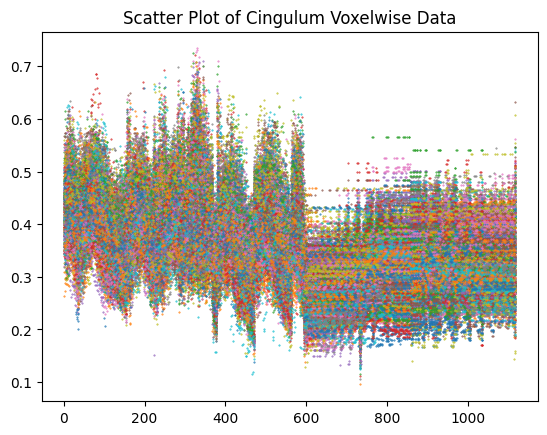

In [3]:
import matplotlib.pyplot as plt

for index, row in cingulum_voxelwise_data.iterrows():
    plt.scatter(range(1, len(row) + 1), row, label = f'Row {index + 1}', s = 0.2)

plt.title("Scatter Plot of Cingulum Voxelwise Data")




Text(0.5, 1.0, 'Scatter Plot of Corpus Voxelwise Data')

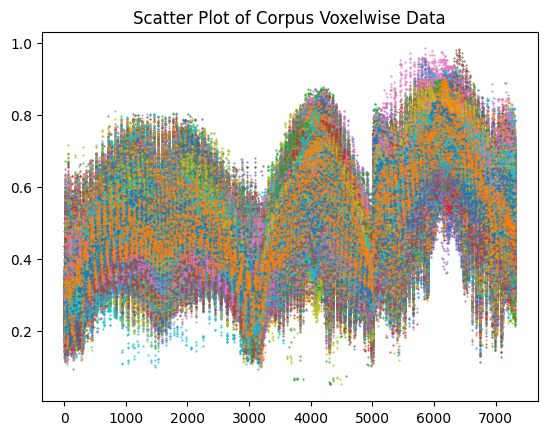

In [4]:
import matplotlib.pyplot as plt


for index, row in corpus_voxelwise_data.iterrows():
    plt.scatter(range(1, len(row) + 1), row, label = f'Row {index + 1}', s = 0.2)

plt.title("Scatter Plot of Corpus Voxelwise Data")



Now I will convert the voxelwise data into functional data that can be used with the model. I will be using a Fourier basis with 50 basis functions.

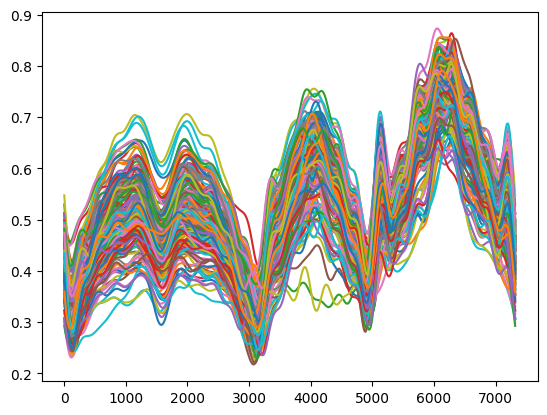

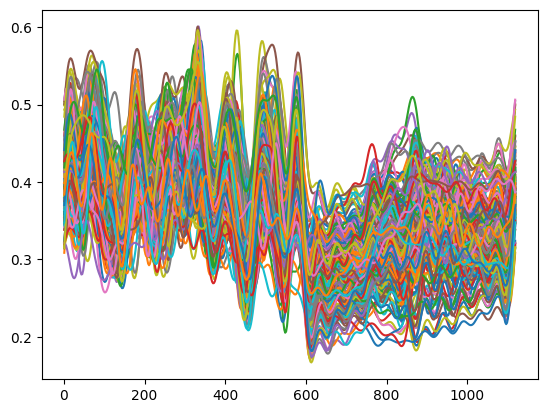

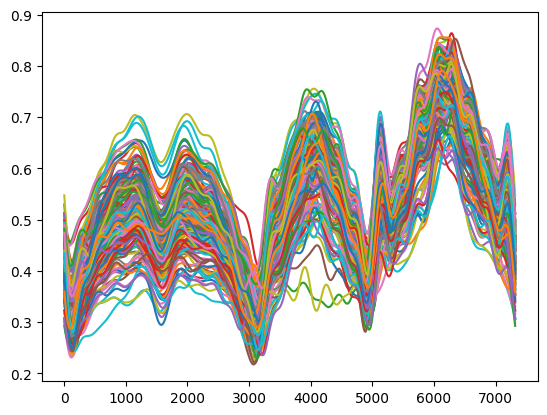

In [5]:
from skfda.representation.basis import FourierBasis 
from skfda.representation.grid import FDataGrid

#X Data 
cingulum_grid_points = np.arange(1, len(cingulum_voxelwise_data_column_names) + 1)
corpus_grid_points = np.arange(1, len(corpus_voxelwise_data_column_names) + 1)

cingulum_fd = FDataGrid(data_matrix=cingulum_voxelwise_data, grid_points=cingulum_grid_points).to_basis(FourierBasis(domain_range=(1, len(cingulum_voxelwise_data_column_names) + 1), n_basis=50))
corpus_fd = FDataGrid(data_matrix=corpus_voxelwise_data, grid_points=corpus_grid_points).to_basis(FourierBasis(domain_range = (1, len(corpus_voxelwise_data_column_names) + 1), n_basis = 50))

cingulum_fd.plot()
corpus_fd.plot()



For the Y Data I will be taking the MMSE Scores for the respective clients, and will form Functional Data using it. I will do this by repeating the MMSE Score the number of points in the Domain. This will create a constant function as the response variable for each MRI Curve

In [6]:
#Y Data
raw_cingulum_y_data = raw_cingulum["MMSE.Total.Score"].to_numpy()
raw_corpus_y_data = raw_corpus["MMSE.Total.Score"].to_numpy()

cingulum_y_data = np.repeat(raw_cingulum_y_data, len(cingulum_voxelwise_data_column_names))
cingulum_y_data.resize((raw_cingulum_y_data.shape[0], len(cingulum_voxelwise_data_column_names)))

corpus_y_data = np.repeat(raw_corpus_y_data, len(corpus_voxelwise_data_column_names))
corpus_y_data.resize((raw_corpus_y_data.shape[0], len(corpus_voxelwise_data_column_names)))

cingulum_fdy = FDataGrid(data_matrix=cingulum_y_data, grid_points=np.arange(1, len(cingulum_voxelwise_data_column_names) + 1)).to_basis(FourierBasis(domain_range=(1, len(cingulum_voxelwise_data_column_names) + 1), n_basis=50))
corpus_fdy = FDataGrid(data_matrix=corpus_y_data, grid_points=np.arange(1, len(corpus_voxelwise_data_column_names) + 1)).to_basis(FourierBasis(domain_range = (1, len(corpus_voxelwise_data_column_names) + 1), n_basis=50))


Now I will run the model with for the Cingulum Data.

In [7]:
import funweightclust as fwc
res = fwc.funweightclust(cingulum_fd, cingulum_fdy, K=2, model="all", modely="all", init="kmeans", nb_rep=1, threshold=0.001)

from sklearn import metrics as met
print("ARI Score:\t", met.adjusted_rand_score(res.cl, cingulum_labels))
print("Confusion Matrix:\n", met.confusion_matrix(res.cl, cingulum_labels))


FunWeightClust:  30.9 secs  |  Approx. remaining:       0.0 secs  |    100% complete 

        Model ModelY  K Threshold Complexity         BIC  \
1    AKJBQKDK    VVI  2     0.001   2,374.00  287,495.37   
2   AKJBKQKDK    EEI  2     0.001   2,352.00  286,673.23   
3   AKJBKQKDK    VVI  2     0.001   2,403.00  286,412.77   
4    AKJBQKDK    EEI  2     0.001   2,294.00  285,132.65   
5      ABQKDK    VVI  2     0.001   2,415.00  277,828.95   
6    AKBKQKDK    EEI  2     0.001   2,264.00  277,178.12   
7    AKBKQKDK    VVI  2     0.001   2,393.00  277,103.22   
8     ABKQKDK    EEI  2     0.001   2,263.00  277,023.89   
9     ABKQKDK    VVI  2     0.001   2,439.00  276,895.15   
10     ABQKDK    EEI  2     0.001   2,364.00  276,273.88   
11    AKBQKDK    EEI  2     0.001   2,263.00  276,213.08   
12    AKBQKDK    VVI  2     0.001   2,286.00  275,566.76   
13  AKJBKQKDK    VII  2     0.001   2,275.00  -51,804.69   
14  AKJBKQKDK    EII  2     0.001   2,274.00  -52,167.13   
15   AKJBQKDK

Next I will run the model with the Corpus Data

In [8]:
import funweightclust as fwc
res = fwc.funweightclust(corpus_fd, corpus_fdy, K=2, model="all", modely="all", init="kmeans", nb_rep=1, threshold=0.001)

from sklearn import metrics as met
print("ARI Score:\t", met.adjusted_rand_score(res.cl, corpus_labels))
print("Confusion Matrix:\n", met.confusion_matrix(res.cl, corpus_labels))

FunWeightClust:  18.0 secs  |  Approx. remaining:       0.0 secs  |    100% complete  

        Model ModelY  K Threshold Complexity         BIC  \
1    AKJBQKDK    EEI  2     0.001   1,616.00  270,132.46   
2   AKJBKQKDK    EEI  2     0.001   1,512.00  269,749.50   
3   AKJBKQKDK    VVI  2     0.001   1,490.00  269,260.99   
4    AKJBQKDK    VVI  2     0.001   1,489.00  269,108.49   
5    AKBKQKDK    VVI  2     0.001   1,498.00  267,305.82   
6     AKBQKDK    EEI  2     0.001   1,585.00  265,538.95   
7      ABQKDK    EEI  2     0.001   1,584.00  265,527.08   
8     ABKQKDK    VVI  2     0.001   1,567.00  265,385.00   
9     AKBQKDK    VVI  2     0.001   1,602.00  265,349.03   
10    ABKQKDK    EEI  2     0.001   1,683.00  265,220.38   
11   AKBKQKDK    EEI  2     0.001   1,617.00  265,190.23   
12     ABQKDK    VVI  2     0.001   1,496.00  265,118.38   
13   AKJBQKDK    EII  2     0.001   1,347.00  -84,347.93   
14  AKJBKQKDK    VII  2     0.001   1,276.00  -86,633.25   
15   AKJBQKD

Now I will implement the model using multivariate data. Our predictional variables will be the original MRI functions, and also the age. The response variable will be the MMSE Score. I will convert the age into functional data much like I did with the Y Data

In [9]:
raw_age = raw_cingulum["Age"].to_numpy()

cingulum_age = np.repeat(raw_age, len(cingulum_voxelwise_data_column_names))
cingulum_age.resize((raw_cingulum_y_data.shape[0], len(cingulum_voxelwise_data_column_names)))

corpus_age = np.repeat(raw_age, len(corpus_voxelwise_data_column_names))
corpus_age.resize((raw_corpus_y_data.shape[0], len((corpus_voxelwise_data_column_names))))

cingulum_age_fd = FDataGrid(data_matrix=cingulum_age, grid_points=np.arange(1, len(cingulum_voxelwise_data_column_names) + 1)).to_basis(FourierBasis(domain_range=(1, len(cingulum_voxelwise_data_column_names) + 1), n_basis=50))
corpus_age_fd = FDataGrid(data_matrix=corpus_age, grid_points=np.arange(1, len(corpus_voxelwise_data_column_names) + 1)).to_basis(FourierBasis(domain_range=(1, len(corpus_voxelwise_data_column_names) + 1), n_basis=50))



In [10]:
fdobj = [cingulum_fd, cingulum_age_fd]
x = fdobj[0].coefficients

for i in range(1, len(fdobj)):
    x = np.c_[x, fdobj[i].coefficients]

x.shape


(212, 102)

Now I will use the model with the Cingulum Data + Age data as a multivariate functional object. I will repeat the same with the corpus data.    

In [11]:
import funweightclust as fwc
res = fwc.funweightclust(fdobj, cingulum_fdy, K=2, model="all", modely="all", init="kmeans", nb_rep=1, threshold=0.001)

from sklearn import metrics as met
print("ARI Score:\t", met.adjusted_rand_score(res.cl, cingulum_labels))
print("Confusion Matrix:\n", met.confusion_matrix(res.cl, cingulum_labels))


FunWeightClust:   1.1 mins  |  Approx. remaining:       0.0 secs  |    100% complete 

        Model ModelY  K Threshold Complexity         BIC  \
1     AKBQKDK    EEI  2     0.001     461.00  292,150.10   
2    AKJBQKDK    EEI  2     0.001     461.00  292,150.10   
3      ABQKDK    EEI  2     0.001     460.00  292,147.89   
4   AKJBKQKDK    EEI  2     0.001     462.00  291,956.24   
5    AKBKQKDK    EEI  2     0.001     462.00  291,956.24   
6     ABKQKDK    EEI  2     0.001     461.00  291,954.95   
7   AKJBKQKDK    VVI  2     0.001     513.00  291,908.90   
8    AKBKQKDK    VVI  2     0.001     513.00  291,908.90   
9     ABKQKDK    VVI  2     0.001     512.00  291,906.98   
10   AKJBQKDK    VVI  2     0.001     512.00  291,891.86   
11    AKBQKDK    VVI  2     0.001     512.00  291,891.86   
12     ABQKDK    VVI  2     0.001     511.00  291,889.66   
13  AKJBKQKDK    VII  2     0.001     413.00  -46,877.41   
14   AKBKQKDK    VII  2     0.001     413.00  -46,877.41   
15    ABKQKDK